In [15]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns

--------------
# Code to change!

In [16]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'bs_C'

# Use theory cov?
use_theory_cov = True

# Information about the sampling
n_burn = 50000
n_steps = 200000

# Samples file (not flat)
upper_samples_not_flat = np.load('./11_15_2023/run0/samples0.npy', allow_pickle = True)
lower_samples_not_flat = np.load('./11_15_2023/run1/samples1.npy', allow_pickle = True)
overlap_region = [1.7, 1.8]
parameter_index = 3

# upper_samples_not_flat = np.load('./11_15_2023/run2/samples2.npy', allow_pickle = True)
# lower_samples_not_flat = np.load('./11_15_2023/run3/samples3.npy', allow_pickle = True)
# overlap_region = [1.5, 1.7] # Overlap region:
# parameter_index = 5 # Parameter index:

# Plot things?
plot_trace = True
plot_prob = False

# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [17]:
# Flatten the samples
len0, len1, len2 = upper_samples_not_flat.shape
upper_samples = np.reshape(upper_samples_not_flat, (len0 * len1, len2))

len0, len1, len2 = lower_samples_not_flat.shape
lower_samples = np.reshape(lower_samples_not_flat, (len0 * len1, len2))

-------------------
Load in the data and normalization info

In [18]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

-------------------
Set the labels and param priors to create the model

In [19]:
# # # Set the parameter bounds and initialize the model
if parameterization == 'standard':
    labels = ['A0', 'r0', 'A1+', 'r1+', 'P1+', 'A1-', 'r1-', 'P1-']
    sys.stderr.write('No Longer Supported....')
    sys.exit(-1)
elif parameterization == 'bound_state':
    labels = ['A0', 'r0', 'r1+', 'P1+', 'r1-', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [-1, 1], [-6, 6], [-1, 1], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [0.0, 0.1], [0.0, 1.6], [0.0, 0.1], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    sys.stderr.write('Not implemented yet...')
    sys.exit(-1)
elif parameterization == 'bs_C':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
elif parameterization == 'init-f-wave':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-', 'r3+']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6], [-3, 0]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6], [-0.5, 1]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.F_Wave_AR(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)

# Add normalization labels
for i in range(0, int(np.max(norm_group) + 1)):
    labels.append('f_{}'.format(i))

-----------------


In [20]:
# Overlap region 
lower_overlap = lower_samples[np.where(lower_samples[:, parameter_index] >= overlap_region[0])[0]]
upper_overlap = upper_samples[np.where(upper_samples[:, parameter_index] <= overlap_region[1])[0]]

n_lower_overlap = lower_overlap.shape[0]
n_upper_overlap = upper_overlap.shape[0]

print('Upper: Tot - {}, Overlap - {}'.format(upper_samples.shape[0], n_upper_overlap))
print('Lower: Tot - {}, Overlap - {}'.format(lower_samples.shape[0], n_lower_overlap))

Upper: Tot - 4888, Overlap - 545
Lower: Tot - 4725, Overlap - 1108


-------------------
# Generate the corner plots

In [21]:
# corner.corner(upper_samples[:, :model.erp_dim], labels = labels[:model.erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
# plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
# plt.show()

In [22]:
# corner.corner(lower_samples[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
# plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
# plt.show()

In [23]:
# overlap = np.concatenate([lower_overlap, upper_overlap])

# corner.corner(overlap[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
# plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
# plt.show()

Throw away samples in the overlap region from ONE of the regions. Don't just add them from both regions.

In [24]:
lower_has_more_overlap = (n_lower_overlap > n_upper_overlap)

if lower_has_more_overlap:
    frac_keep = n_upper_overlap / n_lower_overlap
    n_keep = int(lower_samples.shape[0] * frac_keep)
    keep_indices = np.floor(np.linspace(0, lower_samples.shape[0] - 1, n_keep)).astype(int)
    lower_samples = lower_samples[keep_indices]
    lower_samples = lower_samples[np.where(lower_samples[:, parameter_index] <= overlap_region[0])[0]]
    print('1')
else:
    frac_keep = n_lower_overlap / n_upper_overlap
    n_keep = int(upper_samples.shape[0] * frac_keep)
    keep_indices = np.floor(np.linspace(0, upper_samples.shape[0] - 1, n_keep)).astype(int)
    upper_samples = upper_samples[keep_indices]
    upper_samples = upper_samples[np.where(upper_samples[:, parameter_index] >= overlap_region[1])[0]]
    print('2')


print(frac_keep, upper_samples.shape[0], lower_samples.shape[0])

# print(lower_has_more_overlap, frac_keep, n_keep)
# print('lower_samples: {} | lower_overlap: {} | upper_samples: {} | upper_overlap: {} | n_keep: {}'.format(
#     lower_samples.shape[0], lower_overlap.shape[0], upper_samples.shape[0], upper_overlap.shape[0], n_keep))
# print(frac_keep)
samples = np.concatenate([upper_samples, lower_samples])

1
0.4918772563176895 4888 1786


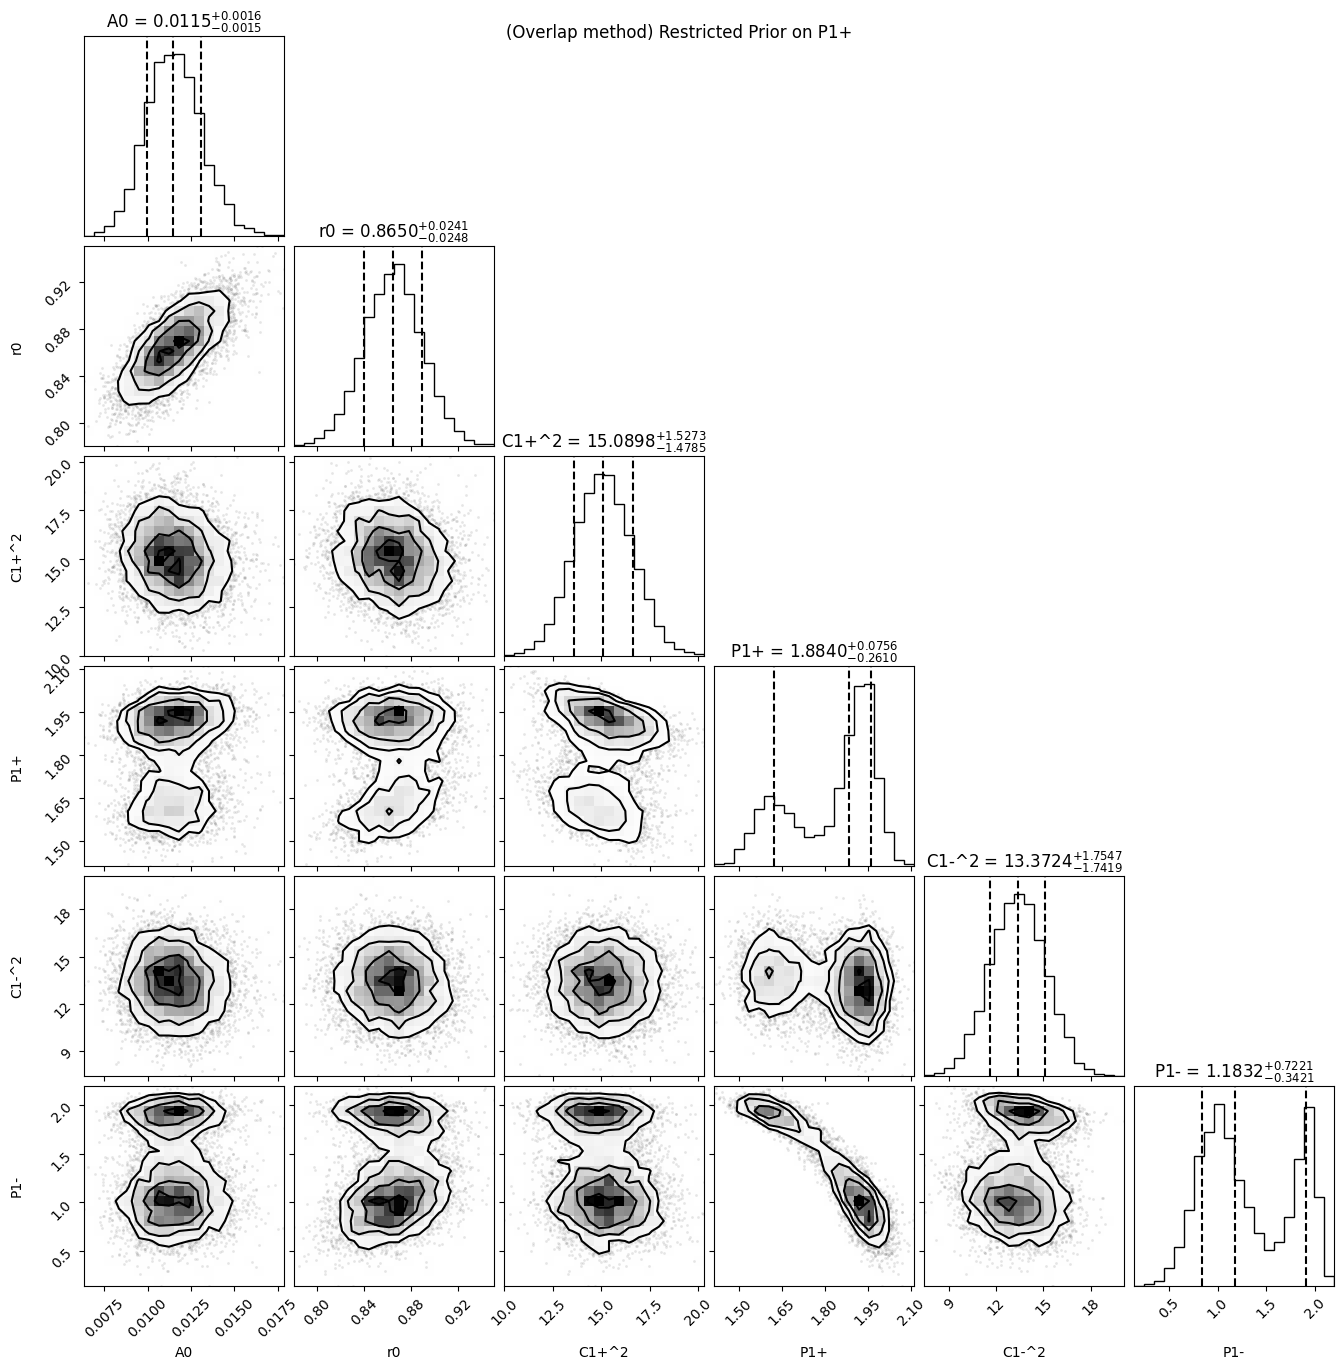

In [25]:
corner.corner(samples[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("(Overlap method) Restricted Prior on {}".format(labels[parameter_index]))
plt.show()

-----------
# Harmonic mean estimator

In [26]:
# Compute the likelihoods for the upper and lower regions
upper_log_likelihoods = [model.log_likelihood(i).real for i in upper_samples]
lower_log_likelihoods = [model.log_likelihood(i).real for i in lower_samples]
upper_likelihoods = np.exp(upper_log_likelihoods)
lower_likelihoods = np.exp(lower_log_likelihoods)

# Get the total counts
m1 = upper_likelihoods.shape[0]
m2 = lower_likelihoods.shape[0]

# Compute the HMEs
hme1 = 1 / (np.sum(1 / upper_likelihoods) / m1)
hme2 = 1 / (np.sum(1 / lower_likelihoods) / m2)

In [27]:
if hme1 >= hme2:
    print('1')
    hme_ratio = hme2 / hme1
    n1 = int(m1)
    n2 = int(hme_ratio * m2)
else:
    print('2')
    hme_ratio = hme1 / hme2
    n1 = int(hme_ratio * m1)
    n2 = int(m2)
    
indices1 = np.random.choice(np.arange(0, m1), n1)
indices2 = np.random.choice(np.arange(0, m2), n2)
hme_samples = np.concatenate([upper_samples[indices1], lower_samples[indices2]])

print(hme_ratio, n1, n2)

2
0.44492969016446404 2174 1786


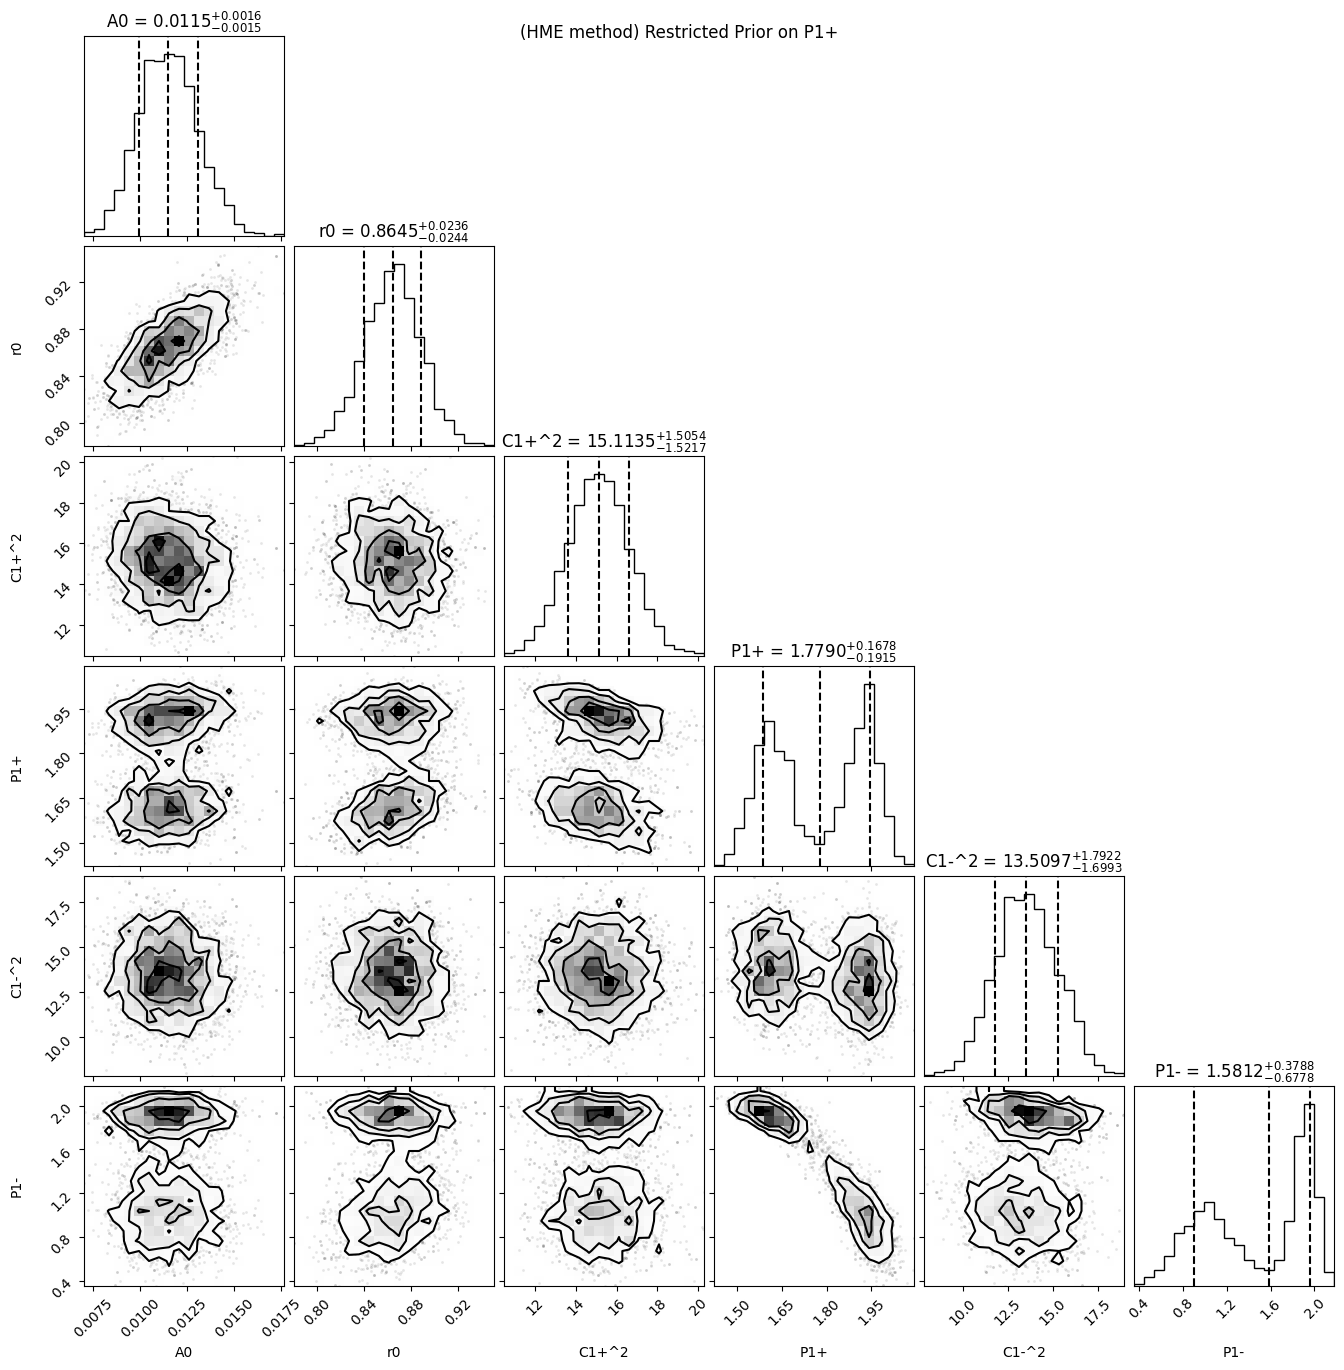

In [28]:
corner.corner(hme_samples[:, :model.erp_dim], labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("(HME method) Restricted Prior on {}".format(labels[parameter_index]))
plt.show()